# Support Vector Machine
In this notebook, we fit a SVM to the regression problem of predicting mean activity based on non-wearable features taken from the UK biobank. 

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)

In [2]:
from accel.read_data import prep_data
from accel.constants import DATA_DIR, DEMO, PHYSICAL

## Data prep

In [3]:
X_train, X_val, X_test, y_train, y_val, y_test, means_modes = prep_data(DATA_DIR / "shared/eliminated-missing-participants.csv",
                                                                        [PHYSICAL],
                                                                        normalise = True,
                                                                        one_hot = True)

In [4]:
print(X_train.shape)
X_train.head()

(60829, 12)


,MET minutes per week for walking | Instance 0,Duration of walks | Instance 0,Body mass index (BMI) | Instance 0,Summed days activity | Instance 0,Above moderate/vigorous recommendation | Instance 0_Yes,Above moderate/vigorous/walking recommendation | Instance 0_Yes,Frequency of stair climbing in last 4 weeks | Instance 0,IPAQ activity group | Instance 0,Above moderate/vigorous recommendation | Instance 0_No,MET minutes per week for vigorous activity | Instance 0,MET minutes per week for moderate activity | Instance 0,Above moderate/vigorous/walking recommendation | Instance 0_No
17537,0.057918,-0.166814,-0.106426,0.918630,1,1,-0.218657,1.065866,0,-0.545487,3.579646,0
77203,-0.637437,-0.534969,0.027618,-0.358617,0,1,-0.218657,-0.311621,1,-0.508467,-0.294569,0
83172,-0.637437,-0.534969,1.193208,0.918630,1,1,0.570276,1.065866,0,1.601703,0.273649,0
74938,-0.960858,0.000000,-0.436555,-0.145743,0,0,0.000000,-0.311621,1,-0.175282,-0.346225,1
29263,3.114248,5.355510,-0.448076,2.195878,1,1,-0.218657,1.065866,0,8.709642,3.579646,0


# Support vector machine

In [5]:
from time import time
from sklearn import svm
from accel.training import model_tune, score

## Timing
Timing how long it takes to fit an SVM to different sizes of data. Keep in mind, there are 69567 training observations.

In [6]:
Ns = np.arange(100,10001,1000)
Ns

array([ 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100])

In [7]:
reps = 5
times = np.zeros((reps,len(Ns)))

for r in range(reps):
    print("Rep",r, "Size:", end="")
    for i in range(len(Ns)):
        print(Ns[i],end=", ")
        N = Ns[i]
        clf = svm.SVR() # default SVR with an RBF kernel
        start = time()
        clf.fit(X_train[:N], y_train[:N ]) #train model and time
        times[r,i] = time() - start
    print()

Rep 0 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 1 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 2 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 3 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 
Rep 4 Size:100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 


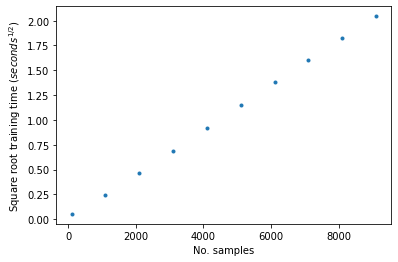

In [8]:
plt.plot(Ns, np.sqrt(np.mean(times,axis=0)), ".")
plt.xlabel("No. samples")
plt.ylabel("Square root training time ($seconds^{1/2}$)")
plt.show()

In [9]:
root_mean_times = np.sqrt(np.mean(times,axis=0))
m = root_mean_times[-1] / Ns[-1]
m

0.00022470676505063002

In [10]:
(m * 9100)

2.0448315619607333

As we can see, the training algorithm is quadratic in the number of samples. We can estimate the time it would take on the full data set as follows:

$N = \text{number of samples}$

$\text{Mean time}^{1/2} = 265\cdot 10^{-4} \times N$

$\text{Mean time} = ( 265\cdot 10^{-4} \times N ) ^2$

In [11]:
N_train = X_train.shape[0]
pred_secs = (m * N_train)**2 #answer in seconds
print("Predicted training time in minutes", pred_secs / 60) # answer in minutes

Predicted training time in minutes 4.072748527030175


In [7]:
# fitting the classifier, which might take 5 minutes
clf = svm.SVR()
start = time()
clf.fit(X_train, y_train) #train model and time
time() - start

245.68137407302856

In [9]:
245/60 # so actually took a bit longer

4.083333333333333

How good is the out the box model?

In [10]:
from accel.training import score

In [11]:
y_pred = clf.predict(X_val)

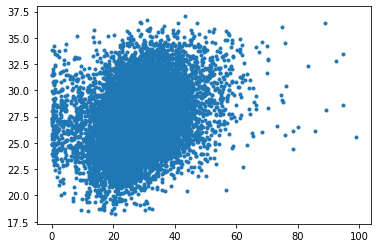

In [12]:
plt.plot(y_val,y_pred, ".")

In [13]:
score(y_val, y_pred)

MSE is:  77.24804483636107
R2 is:  0.09270852412165731
Explained variance is: 0.09581020080377112


## Linear SVM

In [68]:
clf = svm.LinearSVR(loss='squared_epsilon_insensitive', dual=False)
start = time()
clf.fit(X_train, y_train) #train model and time
time() - start

0.0675652027130127

In [69]:
y_pred = clf.predict(X_val)

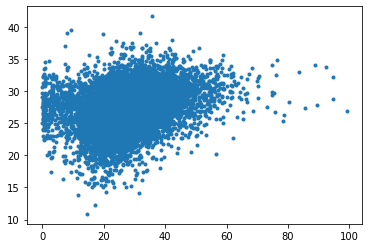

In [70]:
plt.plot(y_val,y_pred, ".")

In [71]:
score(y_val, y_pred)

MSE is:  77.85987314424546
R2 is:  0.08552249618243268
Explained variance is: 0.08561683861145064


# Hyper-parameter tuning
We perform hyper-parameter tuning on the linear SVM since it is less time-consuming to fit

In [6]:
from accel.training import model_tune

In [7]:
y_train.std()

9.31188125134071

In [8]:
np.geomspace(1e-10,1,10)

array([1.00000000e-10, 1.29154967e-09, 1.66810054e-08, 2.15443469e-07,
       2.78255940e-06, 3.59381366e-05, 4.64158883e-04, 5.99484250e-03,
       7.74263683e-02, 1.00000000e+00])

In [9]:
# define lists of params interested in

epsilon = np.geomspace(1e-10,1,10) # size of epsilon 
C = np.geomspace(1e-3,1,10) # Small C -> big regularisation.

params = {
    "epsilon" : epsilon,
    "C"      : C
}

In [10]:
clf = model_tune(svm.LinearSVR(loss='squared_epsilon_insensitive', dual=False, random_state=42), 
                 params, X_train, y_train, 20)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/cdthome/pkd542/.conda/envs/accel/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits


/cdthome/pkd542/.conda/envs/accel/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/cdthome/pkd542/.conda/envs/accel/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameter combo: OrderedDict([('C', 0.1), ('epsilon', 0.005994842503189421)])
Best validation MSE: 0.09695121202418519


In [11]:
clf

LinearSVR(C=0.1, dual=False, epsilon=0.005994842503189421,
          loss='squared_epsilon_insensitive', random_state=42)

MSE is:  75.6023919022447
R2 is:  0.10233762143843472
Explained variance is: 0.10243339827506437


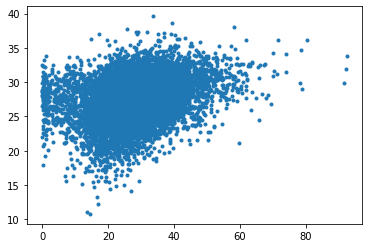

In [13]:
y_pred = clf.predict(X_val)
plt.plot(y_val,y_pred, ".")
_ = score(y_val, y_pred)

## Thoughts
It seems more feasible to train the linear SVM on the full data-set, whereas the SVMs with other kernels would seem to take a lot longer. Next steps should include seeing whether including additional variables improves the model performance.

In [72]:
from accel.constants import DIETARY, SOCIO

In [14]:
X_train, X_val, X_test, y_train, y_val, y_test, means_modes = prep_data(DATA_DIR / "shared/reduced-cohort.csv",
                                                                        normalise = True,
                                                                        one_hot = True)

In [15]:
clf = svm.LinearSVR(loss='squared_epsilon_insensitive', dual=False)
start = time()
clf.fit(X_train, y_train) #train model and time
time() - start

9.336797952651978

In [16]:
clf = model_tune(svm.LinearSVR(loss='squared_epsilon_insensitive', dual=False, random_state=42), 
                 params, X_train, y_train, 20)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

/cdthome/pkd542/.conda/envs/accel/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameter combo: OrderedDict([('C', 0.0021544346900318843), ('epsilon', 1e-10)])
Best validation MSE: 0.17287932034125125


MSE is:  71.90184910801169
R2 is:  0.15550050575671115
Explained variance is: 0.15562302545566353


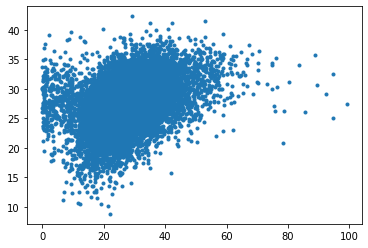

In [17]:
y_pred = clf.predict(X_val)
plt.plot(y_val,y_pred, ".")
_ = score(y_val, y_pred)